# ResNet-Based mmFace

In [20]:
import torch
import torch.nn as nn
# from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=2)
        self.fc1 = nn.Sequential(
            nn.Linear(512*14*6, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, downsample)] + [block(planes, planes) for _ in range(blocks-1)]
        self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        # print(x.shape)
        x = x.view(-1, 512*14*6)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

class MMFace(nn.Module):
    def __init__(self, num_classes=50):
        super(MMFace, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.maxpool =  nn.MaxPool2d(kernel_size=3)
        self.fc1 = nn.Sequential(
            nn.Linear(64*6, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        # Flatten vector before FC layers
        # print(x.shape)
        x = x.view(-1, 64*6)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

cuda


## Loading Dataset and Model

In [2]:
import sys
import numpy as np
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

# Random Subset
subjects = sorted(list(np.random.choice(range(1, 20), 1, replace=False)) + [4, 14, 16, 20])
np.array(anon_names)[subjects]

array(['Joseph Parker', 'Amy Eden', 'Chloë Smart', 'Barkin Bryce',
       'Chaitanya Kaul'], dtype='<U19')

In [2]:
from dataset_builder import normalise, load_dataset_DL, load_dataset
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np

num_frames = 100
# train, validation, test = load_dataset_DL(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), batch_size=128, transform=Compose([normalise, ToTensor()]))

# subjects = [0, 4, 9, 14, 16, 20] -> mmFace-simpl6 45%
# subjects = sorted(np.random.choice(range(19), 4, replace=False))
# subjects = [4, 14, 16, 20] # -> mmFace-simple4 55%
subjects = list(range(21))
num_classes = len(subjects)
experiments = list(range(15))

torch.cuda.empty_cache()
train, validation, test = load_dataset(os.path.relpath("../../Soli/soli_realsense/data"), subjects, experiments=experiments, num_frames=num_frames, batch_size=128)

Train: torch.Size([25200, 3, 32, 16])
Validation: torch.Size([3150, 3, 32, 16])
Test: torch.Size([3150, 3, 32, 16])
Allocated: 0.37 GB


## Hyperparameters + Loss + Optimiser

In [21]:
from utils import load_model, load_history

num_epochs = 20
learning_rate = 0.01

# model = MMFace(num_classes).to(device)

model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)
# model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet50(weights=ResNet50_Weights.DEFAULT)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace100-resnetcustom-{num_classes}.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

# FINETUNING: FREEZE PRETRAINED PARAMETERS FOR FIRST FEW EPOCHS
# for param in model.parameters():
#     param.requires_grad = True
# model = model.to(device)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

[Errno 2] No such file or directory: 'models/mmFace100-resnetcustom-21.pt'


## Training
- Load training data in ***batches*** for every epoch, moving to `device`
  - `train_loader` = `[([data*], [labels*])*]`
- `model(data)` to predict label, then calculate loss between predictions and ground truth labels using `criterion(preds, labels)`
- Backpropagate to learn with `loss.backward()`, and update weights with `optimiser.step()`. Gradients must be reset to 0 after every update with `optimiser.zero_grad()` otherwise gradients will accumulate (default PyTorch).
- After every epoch, test model on validation set but can turn off gradients for faster evaluation using `with torch.no_grad()`.

In [22]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")

    # Stop if overfitting
    if avg_train_acc - avg_val_acc > 10:
        break


Epoch [0/19]:


  0%|          | 0/197 [00:00<?, ?it/s]

torch.Size([128, 512, 14, 6])

  0%|          | 0/197 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x43008 and 4096x512)

## Testing

In [5]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 10.6032%


# Evaluation

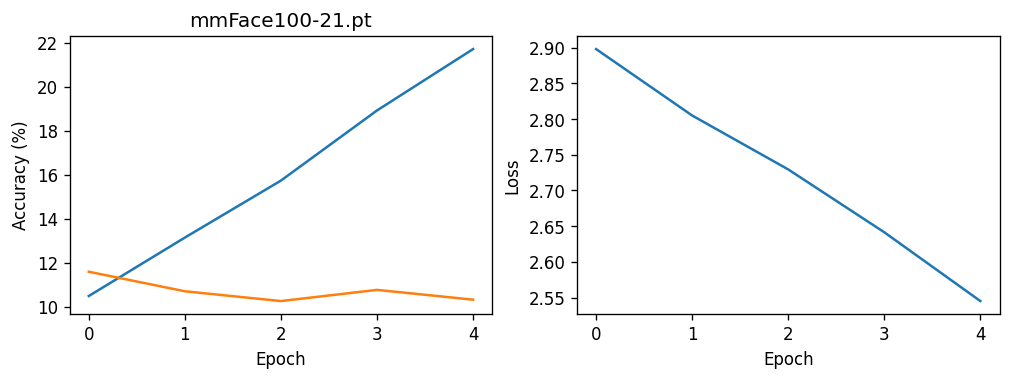

In [6]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

[Text(0.5, 25.222222222222214, 'Predictions'),
 Text(145.22222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

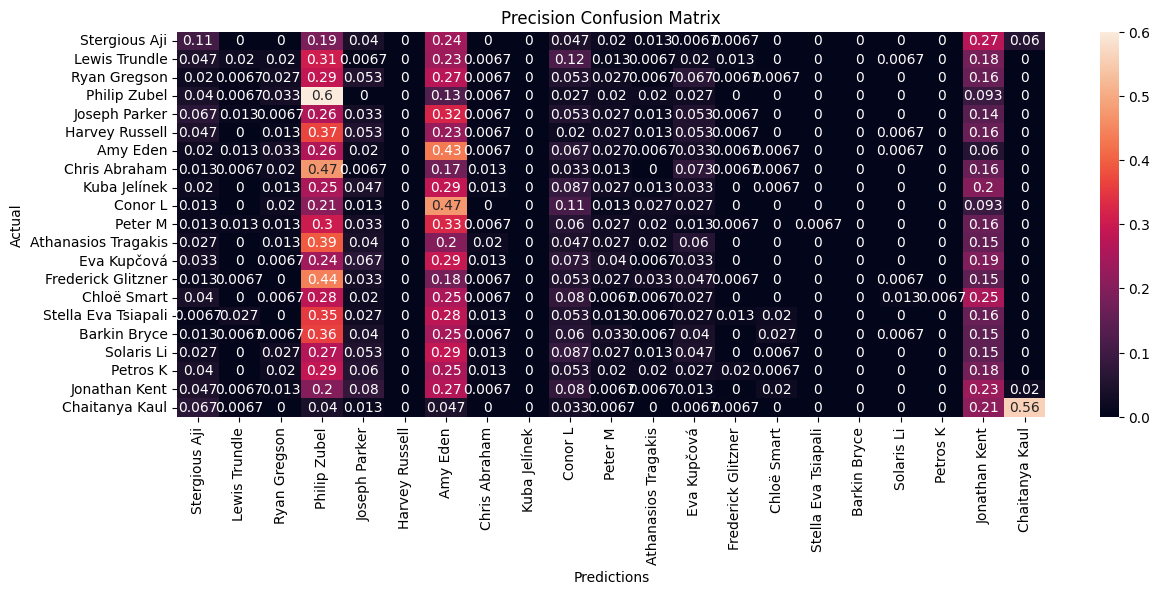

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = np.array(anon_names)[subjects]
# subjects = range(num_classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')